In [1]:
# Python imports
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import tarfile

In [2]:
def open_tar_shapefile(fpath):
    with tarfile.open(fpath, "r:gz") as tar:
        for member in tar.getmembers():
            if '.shp' in member.path:
                fname = member.path
    shpf = gpd.read_file('tar://' + fpath + '/' + fname)
    for f in glob.glob( f"{os.path.dirname(fpath)}/*.properties"):
        os.remove(f)
    return shpf

In [9]:

files = {
'01': '01_alaska',
'02': '02_western_canada_usa',
'03': '03_arctic_canada_north',
'04': '04_arctic_canada_south',
'05': '05_greenland_periphery',
'06': '06_iceland',
'07': '07_svalbard_jan_mayen',
'08': '08_scandinavia',
'09': '09_russian_arctic',
'10': '10_north_asia',
'11': '11_central_europe',
'12': '12_caucasus_middle_east',
'13': '13_central_asia',
'14': '14_south_asia_west',
'15': '15_south_asia_east',
'16': '16_low_latitudes',
'17': '17_southern_andes',
'18': '18_new_zealand',
'19': '19_subantarctic_antarctic_islands',
}

In [10]:
rgi_reg_df = []
for rgi_reg in range(1, 20):
    rgi_reg = f'{rgi_reg:02d}'
    fp = f'/home/www/fmaussion/misc/rgi7_data/l4_rgi7b0/RGI2000-v7.0-G-{files[rgi_reg]}/RGI2000-v7.0-G-{files[rgi_reg]}-attributes.csv'
    rgi_reg_df.append(pd.read_csv(fp, index_col=0))
rgi_reg_df = pd.concat(rgi_reg_df)

In [11]:
df_stats = []
for rgi_reg in range(1, 20):
    rgi_reg = f'{rgi_reg:02d}'
    tmp = pd.read_csv(f'output_vardx/hypsometry_rgi{rgi_reg}_COPDEM30.csv', index_col=0)
    df_stats.append(tmp)
df_stats = pd.concat(df_stats)

In [12]:
assert len(df_stats) == len(rgi_reg_df)

In [13]:
rgi_reg_df.loc[~rgi_reg_df.index.isin(df_stats.index)]

Empty DataFrame
Columns: [o1region, o2region, glims_id, anlys_id, subm_id, src_date, cenlon, cenlat, utm_zone, area_km2, primeclass, conn_lvl, surge_type, term_type, glac_name, is_rgi6, termlon, termlat, zmin_m, zmax_m, zmed_m, zmean_m, slope_deg, aspect_deg, aspect_sec, dem_source, lmax_m]
Index: []

[0 rows x 27 columns]

In [14]:
assert len(df_stats.dropna(how='all')) == len(rgi_reg_df)

In [21]:
for rgi_reg in range(1, 20):
    reg = f'{rgi_reg:02d}'
    min_range = 5
    
    # Ref - RGI
    fp = f'/home/www/fmaussion/misc/rgi7_data/l4_rgi7b0/RGI2000-v7.0-G-{files[reg]}/RGI2000-v7.0-G-{files[reg]}-attributes.csv'
    rgi_reg_df = pd.read_csv(fp, index_col=0)
    
    # Take COPDEM30 for a start
    source = 'COPDEM30'
    fp = f'output_vardx/hypsometry_rgi{reg}_{source}.csv'
    hdf = pd.read_csv(fp, index_col=0)

    ids = np.where(hdf.columns.values == 'dem_source')[0][0]
    attr_cols = list(hdf.columns[0:ids+1])
    hypso_cols = list(hdf.columns[ids+1:])

    hdf_stats = hdf[attr_cols].copy()
    hdf_hypso = hdf[hypso_cols]
    
    valid = (hdf_stats.grid_dx <= 60) & (hdf_stats.valid_dem_perc > 0.99)
    valid = valid & (hdf_stats.zmin_m > -99) & ((hdf_stats.zmax_m - hdf_stats.zmin_m) > min_range)
    output_stats = hdf_stats.loc[valid].copy()
    output_hypso = hdf_hypso.loc[valid].copy()
    
    # Continue with COPDEM90
    source = 'COPDEM90'
    fp = f'output_vardx/hypsometry_rgi{reg}_{source}.csv'

    hdf = pd.read_csv(fp, index_col=0)

    ids = np.where(hdf.columns.values == 'dem_source')[0][0]
    attr_cols = list(hdf.columns[0:ids+1])
    hypso_cols = list(hdf.columns[ids+1:])

    hdf_stats = hdf[attr_cols].copy()
    hdf_hypso = hdf[hypso_cols]
    
    valid = (~ hdf_stats.index.isin(output_stats.index)) & (hdf_stats.valid_dem_perc > 0.99) 
    valid = valid & (hdf_stats.zmin_m > -99) & ((hdf_stats.zmax_m - hdf_stats.zmin_m) > min_range)
    output_stats = pd.concat([output_stats, hdf_stats.loc[valid].copy()]).sort_index()
    output_hypso = pd.concat([output_hypso, hdf_hypso.loc[valid].copy()]).sort_index()
    
    still_no_good = rgi_reg_df.loc[~ rgi_reg_df.index.isin(output_stats.index)]
    print(f'{reg}: After COPDEM, {len(still_no_good)} left bad.')
    if len(still_no_good) == 0:
        continue
    
    for rang in [min_range, 1]:
        for source in ['NASADEM', 'RAMP', 'DEM3', 'ASTER', 'TANDEM']:

            fp = f'output_vardx/hypsometry_rgi{reg}_{source}.csv'
            hdf = pd.read_csv(fp, index_col=0)
            if 'valid_dem_perc' not in hdf:
                continue

            ids = np.where(hdf.columns.values == 'dem_source')[0][0]
            attr_cols = list(hdf.columns[0:ids+1])
            hypso_cols = list(hdf.columns[ids+1:])

            hdf = hdf.loc[still_no_good.index]

            ids = np.where(hdf.columns.values == 'dem_source')[0][0]
            attr_cols = list(hdf.columns[0:ids+1])
            hypso_cols = list(hdf.columns[ids+1:])

            hdf_stats = hdf[attr_cols].copy()
            hdf_hypso = hdf[hypso_cols]

            valid = (~ hdf_stats.index.isin(output_stats.index)) & (hdf_stats.valid_dem_perc > 0.99) 
            valid = valid & (hdf_stats.zmin_m > -99) & ((hdf_stats.zmax_m - hdf_stats.zmin_m) > rang)
            if len(hdf_stats.loc[valid].copy()) == 0:
                continue
            print(f'{reg}: {source} and minrange {rang} can take over for {len(hdf_stats.loc[valid].copy())}')
            output_stats = pd.concat([output_stats, hdf_stats.loc[valid].copy()]).sort_index()
            output_hypso = pd.concat([output_hypso, hdf_hypso.loc[valid].copy()]).sort_index()
            still_no_good = rgi_reg_df.loc[~ rgi_reg_df.index.isin(output_stats.index)]

            print(f'{reg}: After {source} and minrange {rang}, {len(still_no_good)} left bad.')
            if len(still_no_good) == 0:
                break

01: After COPDEM, 0 left bad.
02: After COPDEM, 0 left bad.
03: After COPDEM, 0 left bad.
04: After COPDEM, 9 left bad.
04: DEM3 and minrange 5 can take over for 5
04: After DEM3 and minrange 5, 4 left bad.
04: ASTER and minrange 5 can take over for 4
04: After ASTER and minrange 5, 0 left bad.
05: After COPDEM, 0 left bad.
06: After COPDEM, 0 left bad.
07: After COPDEM, 0 left bad.
08: After COPDEM, 0 left bad.
09: After COPDEM, 0 left bad.
10: After COPDEM, 0 left bad.
11: After COPDEM, 0 left bad.
12: After COPDEM, 0 left bad.
13: After COPDEM, 0 left bad.
14: After COPDEM, 0 left bad.
15: After COPDEM, 0 left bad.
16: After COPDEM, 0 left bad.
17: After COPDEM, 0 left bad.
18: After COPDEM, 0 left bad.
19: After COPDEM, 119 left bad.
19: RAMP and minrange 5 can take over for 20
19: After RAMP and minrange 5, 99 left bad.
19: DEM3 and minrange 5 can take over for 15
19: After DEM3 and minrange 5, 84 left bad.
19: ASTER and minrange 5 can take over for 10
19: After ASTER and minrange

Empty DataFrame
Columns: [o1region, o2region, glims_id, anlys_id, subm_id, src_date, cenlon, cenlat, utm_zone, area_km2, primeclass, conn_lvl, surge_type, term_type, glac_name, is_rgi6, termlon, termlat, zmin_m, zmax_m, zmed_m, zmean_m, slope_deg, aspect_deg, aspect_sec, dem_source, lmax_m]
Index: []

[0 rows x 27 columns]

Still no good: 0
Still no good: 0
Still no good: 0
Still no good: 0
Still no good: 0


In [327]:
# Continue with other range
min_range = 1
for source in ['NASADEM', 'RAMP', 'DEM3', 'ASTER', 'TANDEM']:
    print(f'Still no good: {len(still_no_good)}')
    
    fp = f'output_vardx/hypsometry_rgi{reg}_{source}.csv'
    hdf = pd.read_csv(fp, index_col=0)
    if 'valid_dem_perc' not in hdf:
        continue
        
    ids = np.where(hdf.columns.values == 'dem_source')[0][0]
    attr_cols = list(hdf.columns[0:ids+1])
    hypso_cols = list(hdf.columns[ids+1:])
        
    hdf = hdf.loc[still_no_good.index]

    ids = np.where(hdf.columns.values == 'dem_source')[0][0]
    attr_cols = list(hdf.columns[0:ids+1])
    hypso_cols = list(hdf.columns[ids+1:])

    hdf_stats = hdf[attr_cols].copy()
    hdf_hypso = hdf[hypso_cols]
    
    valid = (~ hdf_stats.index.isin(output_stats.index)) & (hdf_stats.valid_dem_perc > 0.99) 
    valid = valid & (hdf_stats.zmin_m > -99) & ((hdf_stats.zmax_m - hdf_stats.zmin_m) > min_range)
    if len(hdf_stats.loc[valid].copy()) == 0:
        continue
    print(f'{source} can take over for {len(hdf_stats.loc[valid].copy())}')
    output_stats = pd.concat([output_stats, hdf_stats.loc[valid].copy()]).sort_index()
    output_hypso = pd.concat([output_hypso, hdf_hypso.loc[valid].copy()]).sort_index()
    still_no_good = rgi_reg_df.loc[~ rgi_reg_df.index.isin(output_stats.index)]
    if len(still_no_good) == 0:
        break

Still no good: 69
Still no good: 69
RAMP can take over for 1
Still no good: 68
Still no good: 68
Still no good: 68
TANDEM can take over for 34


In [330]:
still_no_good.anlys_id.values

array([287320, 288730, 287588, 288986, 287557, 288951, 287295, 288439,
       288810, 287243, 289386, 289257, 287760, 289955, 289940, 289964,
       289604, 288734, 288701, 287672, 287496, 287944, 288023, 289804,
       287916, 287236, 289553, 288125, 288914, 287331, 289850, 288877,
       287999, 288650])

In [350]:
import shapely.geometry as shpg
geoms = [shpg.Point(x, y) for x, y in zip(output_stats.terminus_lon, output_stats.terminus_lat)]

In [351]:
output_stats['geometry'] = geoms

In [352]:
odf = gpd.GeoDataFrame(output_stats)

In [353]:
odf.crs = 'EPSG:4326'

In [354]:
odf.to_file('term_points_rgi01.shp')

/tmp/ipykernel_3805275/92613193.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  odf.to_file('term_points_rgi01.shp')


In [356]:
[len(c) for c in odf.columns]

[8, 13, 14, 7, 6, 6, 6, 7, 12, 12, 9, 10, 10, 10, 8]

In [357]:
odf.columns

Index(['area_km2', 'area_grid_km2', 'valid_dem_perc', 'grid_dx', 'zmin_m',
       'zmax_m', 'zmed_m', 'zmean_m', 'terminus_lon', 'terminus_lat',
       'slope_deg', 'aspect_deg', 'aspect_sec', 'dem_source', 'geometry'],
      dtype='object')

In [338]:
odf

area_km2  area_grid_km2  valid_dem_perc  grid_dx  \
rgi_id                                                                        
RGI2000-v7.0-G-19-00001    0.037275       0.037856             1.0     13.0   
RGI2000-v7.0-G-19-00002   18.676065      18.621454             1.0     71.0   
RGI2000-v7.0-G-19-00003   15.846683      15.820992             1.0     66.0   
RGI2000-v7.0-G-19-00004    1.975872       1.981800             1.0     30.0   
RGI2000-v7.0-G-19-00005   29.648423      29.606188             1.0     86.0   
...                             ...            ...             ...      ...   
RGI2000-v7.0-G-19-02772  188.556385     188.440000             1.0    100.0   
RGI2000-v7.0-G-19-02773  503.235510     502.990000             1.0    100.0   
RGI2000-v7.0-G-19-02774   48.779761      48.740000             1.0    100.0   
RGI2000-v7.0-G-19-02775  443.394111     443.080000             1.0    100.0   
RGI2000-v7.0-G-19-02776  465.811025     465.480000             1.0    100.0   

                            zmin_m       zmax_m     zmed_m    zmean_m  \
rgi_id                                                                  
RGI2000-v7.0-G-19-00001  -1.381760   200.799970  159.02127  137.64170   
RGI2000-v7.0-G-19-00002  -4.060308  1488.858400  414.09503  533.66460   
RGI2000-v7.0-G-19-00003  -5.749241  1395.004200  461.71710  495.30917   
RGI2000-v7.0-G-19-00004   0.441205   589.155330  282.07822  280.03632   
RGI2000-v7.0-G-19-00005  -1.988455  1524.621500  486.60294  549.99850   
...                            ...          ...        ...        ...   
RGI2000-v7.0-G-19-02772  51.334140   190.581200  119.21578  120.04070   
RGI2000-v7.0-G-19-02773  -2.147076   266.489380  131.61113  135.94368   
RGI2000-v7.0-G-19-02774   4.757297   107.698586   65.82977   65.03951   
RGI2000-v7.0-G-19-02775   6.294697   261.422030  156.44052  153.55705   
RGI2000-v7.0-G-19-02776  -2.018840   352.334080  182.37610  185.75215   

                         terminus_lon  terminus_lat  slope_deg  aspect_deg  \
rgi_id                                                                       
RGI2000-v7.0-G-19-00001    -90.721245    -68.855827  50.257217  269.388718   
RGI2000-v7.0-G-19-00002    -90.670069    -68.907818  15.161851  245.054619   
RGI2000-v7.0-G-19-00003    -90.611171    -68.916908  11.712462  187.647705   
RGI2000-v7.0-G-19-00004    -90.573779    -68.917420  17.433329  199.252274   
RGI2000-v7.0-G-19-00005    -90.465085    -68.887413  11.222229  140.187620   
...                               ...           ...        ...         ...   
RGI2000-v7.0-G-19-02772     -3.411459    -71.066908   1.384531  325.807697   
RGI2000-v7.0-G-19-02773      1.385792    -70.037876   1.436012  342.096767   
RGI2000-v7.0-G-19-02774      2.055546    -70.589927   1.445538  355.737166   
RGI2000-v7.0-G-19-02775      3.197343    -70.386690   1.594081  310.365845   
RGI2000-v7.0-G-19-02776      4.272458    -70.254745   1.858386  302.110531   

                         aspect_sec dem_source                     geometry  
rgi_id                                                                       
RGI2000-v7.0-G-19-00001         7.0   COPDEM30  POINT (-90.72124 -68.85583)  
RGI2000-v7.0-G-19-00002         6.0   COPDEM90  POINT (-90.67007 -68.90782)  
RGI2000-v7.0-G-19-00003         5.0   COPDEM90  POINT (-90.61117 -68.91691)  
RGI2000-v7.0-G-19-00004         5.0   COPDEM30  POINT (-90.57378 -68.91742)  
RGI2000-v7.0-G-19-00005         4.0   COPDEM90  POINT (-90.46508 -68.88741)  
...                             ...        ...                          ...  
RGI2000-v7.0-G-19-02772         8.0   COPDEM90   POINT (-3.41146 -71.06691)  
RGI2000-v7.0-G-19-02773         1.0   COPDEM90    POINT (1.38579 -70.03788)  
RGI2000-v7.0-G-19-02774         1.0   COPDEM90    POINT (2.05555 -70.58993)  
RGI2000-v7.0-G-19-02775         8.0   COPDEM90    POINT (3.19734 -70.38669)  
RGI2000-v7.0-G-19-02776         8.0   COPDEM90    POINT (4.27246 -70.25474)  

[2742 rows x 15 col

In [149]:
output_stats.index

Index(['RGI2000-v7.0-G-01-00001', 'RGI2000-v7.0-G-01-00002',
       'RGI2000-v7.0-G-01-00003', 'RGI2000-v7.0-G-01-00004',
       'RGI2000-v7.0-G-01-00005', 'RGI2000-v7.0-G-01-00006',
       'RGI2000-v7.0-G-01-00007', 'RGI2000-v7.0-G-01-00008',
       'RGI2000-v7.0-G-01-00009', 'RGI2000-v7.0-G-01-00010',
       ...
       'RGI2000-v7.0-G-01-27501', 'RGI2000-v7.0-G-01-27502',
       'RGI2000-v7.0-G-01-27503', 'RGI2000-v7.0-G-01-27504',
       'RGI2000-v7.0-G-01-27505', 'RGI2000-v7.0-G-01-27506',
       'RGI2000-v7.0-G-01-27507', 'RGI2000-v7.0-G-01-27508',
       'RGI2000-v7.0-G-01-27509', 'RGI2000-v7.0-G-01-27510'],
      dtype='object', name='rgi_id', length=27509)

In [150]:
rgi_reg_df.index

Index(['RGI2000-v7.0-G-19-00001', 'RGI2000-v7.0-G-19-00002',
       'RGI2000-v7.0-G-19-00003', 'RGI2000-v7.0-G-19-00004',
       'RGI2000-v7.0-G-19-00005', 'RGI2000-v7.0-G-19-00006',
       'RGI2000-v7.0-G-19-00007', 'RGI2000-v7.0-G-19-00008',
       'RGI2000-v7.0-G-19-00009', 'RGI2000-v7.0-G-19-00010',
       ...
       'RGI2000-v7.0-G-19-02767', 'RGI2000-v7.0-G-19-02768',
       'RGI2000-v7.0-G-19-02769', 'RGI2000-v7.0-G-19-02770',
       'RGI2000-v7.0-G-19-02771', 'RGI2000-v7.0-G-19-02772',
       'RGI2000-v7.0-G-19-02773', 'RGI2000-v7.0-G-19-02774',
       'RGI2000-v7.0-G-19-02775', 'RGI2000-v7.0-G-19-02776'],
      dtype='object', name='rgi_id', length=2776)

In [148]:
still_no_good

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
NASADEM -> GIMP -> RAMP -> DEM3 -> ASTER -> TANDEM 

In [69]:
df_hypso = []
for fp in glob.glob(f'output_vardx/hypsometry_rgi{reg}_*.csv'):
    tmp = pd.read_csv(fp, index_col=0)
    if 'valid_dem_perc' not in tmp:
        continue
    df_hypso.append(tmp)
df_hypso = pd.concat(df_hypso)

In [70]:
ids = np.where(df_hypso.columns.values == 'dem_source')[0][0]
attr_cols = df_hypso.columns[0:ids+1]
hypso_cols = ['dem_source'] + list(df_hypso.columns[ids+1:])
# attr_cols, hypso_cols

In [72]:
df_hypso_stats = df_hypso[attr_cols].copy()
df_hypso = df_hypso[hypso_cols]

In [110]:
reg_hypso = pd.DataFrame()
for source in df_hypso.dem_source.unique():
    tt = df_hypso.loc[df_hypso.dem_source == source].drop('dem_source', axis=1).T
    tt.index = tt.index.astype(int)
    tt = tt.sort_index()
    reg_hypso[source] = tt.loc[-25:].sum(axis=1)

In [112]:
reg_hypso

ALASKA  COPDEM90   ASTER  ARCTICDEM  NASADEM    SRTM  AW3D30    DEM3  \
-25      21.0      28.0    18.0        0.0      2.0     0.0     2.0    15.0   
 25     484.0    1073.0   711.0      215.0    106.0    63.0   337.0   411.0   
 75    3223.0    4076.0  3311.0     1911.0    658.0   523.0  2410.0  1183.0   
 125   5226.0    5942.0  4908.0     3369.0   1989.0  1788.0  4073.0  1824.0   
 175   6891.0    7786.0  7570.0     5161.0   2609.0  2141.0  5448.0  4027.0   
...       ...       ...     ...        ...      ...     ...     ...     ...   
 5975    17.0      29.0    12.0        0.0      0.0     0.0     0.0    19.0   
 6025    17.0      19.0    19.0        0.0      0.0     0.0     0.0    19.0   
 6075    16.0       6.0    13.0        0.0      0.0     0.0     0.0    22.0   
 6125     7.0       0.0     4.0        0.0      0.0     0.0     0.0     7.0   
 6175     0.0       0.0     0.0        0.0      0.0     0.0     0.0     0.0   

       TANDEM  COPDEM30  MAPZEN  
-25      15.0      29.0    29.0  
 25     713.0    1073.0   804.0  
 75    3160.0    4082.0  3059.0  
 125   5411.0    6170.0  5359.0  
 175   6415.0    7493.0  8262.0  
...       ...       ...     ...  
 5975    11.0      29.0    17.0  
 6025     0.0      19.0    19.0  
 6075     0.0       6.0    16.0  
 6125     0.0       0.0     8.0  
 6175     0.0       0.0     0.0  

[125 rows x 11 columns]

In [116]:
df_hypso[['dem_source', '5975']].dropna()

dem_source  5975
rgi_id                                  
RGI2000-v7.0-G-01-04458     ALASKA   1.0
RGI2000-v7.0-G-01-06486     ALASKA  16.0
RGI2000-v7.0-G-01-04458   COPDEM90   1.0
RGI2000-v7.0-G-01-06486   COPDEM90  28.0
RGI2000-v7.0-G-01-04458      ASTER   1.0
RGI2000-v7.0-G-01-06486      ASTER  11.0
RGI2000-v7.0-G-01-04458       DEM3   1.0
RGI2000-v7.0-G-01-06486       DEM3  18.0
RGI2000-v7.0-G-01-06486     TANDEM  11.0
RGI2000-v7.0-G-01-04458   COPDEM30   1.0
RGI2000-v7.0-G-01-06486   COPDEM30  28.0
RGI2000-v7.0-G-01-04458     MAPZEN   1.0
RGI2000-v7.0-G-01-06486     MAPZEN  16.0

In [107]:
df_hypso[['dem_source', '-75']].dropna().dem_source.unique()

array(['TANDEM', 'MAPZEN'], dtype=object)

In [108]:
df_hypso[['dem_source', '-25']].dropna().dem_source.unique()

array(['ALASKA', 'COPDEM90', 'ASTER', 'NASADEM', 'AW3D30', 'DEM3',
       'TANDEM', 'COPDEM30', 'MAPZEN'], dtype=object)

In [109]:
df_hypso[['dem_source', '-25']].dropna()

dem_source  -25
rgi_id                                 
RGI2000-v7.0-G-01-08603     ALASKA  0.0
RGI2000-v7.0-G-01-08669     ALASKA  5.0
RGI2000-v7.0-G-01-08766     ALASKA  2.0
RGI2000-v7.0-G-01-09260     ALASKA  0.0
RGI2000-v7.0-G-01-09288     ALASKA  4.0
...                            ...  ...
RGI2000-v7.0-G-01-26334     MAPZEN  1.0
RGI2000-v7.0-G-01-26335     MAPZEN  1.0
RGI2000-v7.0-G-01-26336     MAPZEN  1.0
RGI2000-v7.0-G-01-26451     MAPZEN  1.0
RGI2000-v7.0-G-01-27508     MAPZEN  3.0

[189 rows x 2 columns]

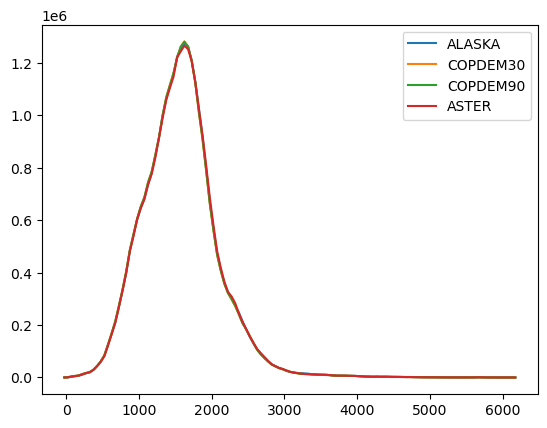

In [113]:
reg_hypso[['ALASKA', 'COPDEM30', 'COPDEM90', 'ASTER']].plot();

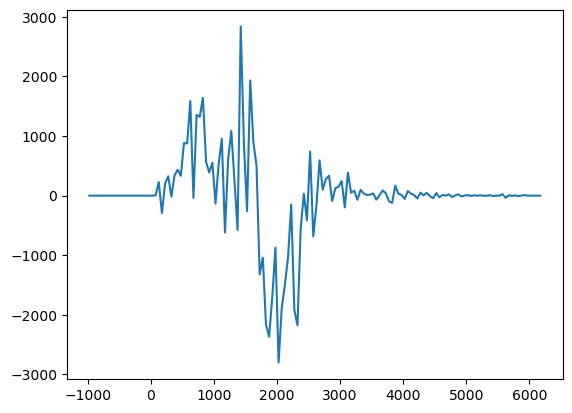

In [96]:
(reg_hypso['COPDEM30'] -  reg_hypso['COPDEM90']).plot();

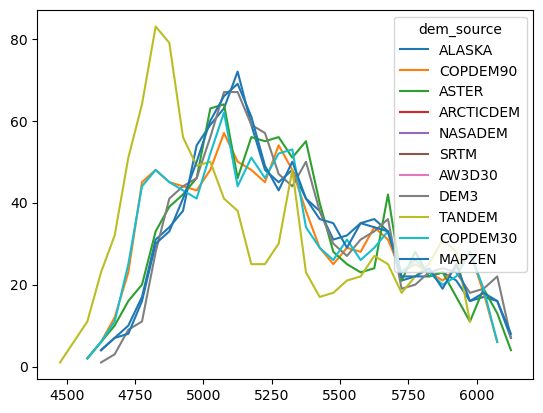

In [122]:
pick = df_hypso.loc['RGI2000-v7.0-G-01-06486'].set_index('dem_source', drop=True).T
pick.index = pick.index.astype(int)
pick = pick.sort_index().loc[-25:]
pick.plot();

In [123]:
df_hypso_stats

area_km2  area_grid_km2  valid_dem_perc  grid_dx  \
rgi_id                                                                      
RGI2000-v7.0-G-01-00001  0.239199       0.240159             1.0     17.0   
RGI2000-v7.0-G-01-00002  0.104641       0.103950             1.0     15.0   
RGI2000-v7.0-G-01-00003  0.216605       0.215883             1.0     17.0   
RGI2000-v7.0-G-01-00004  0.252649       0.253164             1.0     17.0   
RGI2000-v7.0-G-01-00005  0.474716       0.473200             1.0     20.0   
...                           ...            ...             ...      ...   
RGI2000-v7.0-G-01-27506  0.190275       0.192512             1.0     16.0   
RGI2000-v7.0-G-01-27507  0.230076       0.230622             1.0     17.0   
RGI2000-v7.0-G-01-27508  0.187298       0.187904             1.0     16.0   
RGI2000-v7.0-G-01-27509  0.152301       0.152550             1.0     15.0   
RGI2000-v7.0-G-01-27510  0.124837       0.123750             1.0     15.0   

                             zmin_m     zmax_m     zmed_m     zmean_m  \
rgi_id                                                                  
RGI2000-v7.0-G-01-00001  1486.28440  1699.1908  1546.2202  1555.32850   
RGI2000-v7.0-G-01-00002  1278.11840  1399.1879  1326.9348  1329.77330   
RGI2000-v7.0-G-01-00003  1296.45040  1709.8772  1424.0858  1437.20970   
RGI2000-v7.0-G-01-00004  1222.85700  1294.1028  1250.5632  1250.16100   
RGI2000-v7.0-G-01-00005  1053.39660  1478.6954  1290.1498  1273.44210   
...                             ...        ...        ...         ...   
RGI2000-v7.0-G-01-27506  1863.34730  2093.5269  1968.3014  1969.47670   
RGI2000-v7.0-G-01-27507   333.42673  2391.9106  2056.2974  2046.10620   
RGI2000-v7.0-G-01-27508  -143.82372  2155.7637  1916.3992  1852.56240   
RGI2000-v7.0-G-01-27509  1999.61340  2219.7870  2134.6191  2131.66300   
RGI2000-v7.0-G-01-27510   661.06990   839.7798   750.3838   744.54926   

                         terminus_lon  terminus_lat  slope_deg  aspect_deg  \
rgi_id                                                                       
RGI2000-v7.0-G-01-00001   -155.903880     67.415938  18.136948  343.075123   
RGI2000-v7.0-G-01-00002   -155.879472     67.420523  19.511599  349.885915   
RGI2000-v7.0-G-01-00003   -155.531086     67.435518  23.937820   16.654608   
RGI2000-v7.0-G-01-00004   -155.503822     67.433383  13.296009   50.224747   
RGI2000-v7.0-G-01-00005   -155.498990     67.438932  17.073767  303.868996   
...                               ...           ...        ...         ...   
RGI2000-v7.0-G-01-27506   -127.939687     58.382237  28.239532   25.864597   
RGI2000-v7.0-G-01-27507   -128.000195     58.376001  28.140055   87.298850   
RGI2000-v7.0-G-01-27508   -128.000077     58.378432  34.538590   38.816135   
RGI2000-v7.0-G-01-27509   -128.140488     58.381111  23.857056   73.930660   
RGI2000-v7.0-G-01-27510   -131.227253     55.688028  19.334478    2.644879   

                         aspect_sec dem_source  
rgi_id                                          
RGI2000-v7.0-G-01-00001         1.0     ALASKA  
RGI2000-v7.0-G-01-00002         1.0     ALASKA  
RGI2000-v7.0-G-01-00003         1.0     ALASKA  
RGI2000-v7.0-G-01-00004         2.0     ALASKA  
RGI2000-v7.0-G-01-00005         8.0     ALASKA  
...                             ...        ...  
RGI2000-v7.0-G-01-27506         2.0     MAPZEN  
RGI2000-v7.0-G-01-27507         3.0     MAPZEN  
RGI2000-v7.0-G-01-27508         2.0     MAPZEN  
RGI2000-v7.0-G-01-27509         3.0     MAPZEN  
RGI2000-v7.0-G-01-27510         1.0     MAPZEN  

[302610 rows x 14 columns]

In [54]:
reg_hypso

Empty DataFrame
Columns: [ALASKA, COPDEM90, ASTER, ARCTICDEM, GIMP, NASADEM, SRTM, REMA, AW3D30, DEM3, TANDEM, RAMP, COPDEM30, MAPZEN]
Index: []

In [20]:
df_stats.COPDEM30.unique()

array([ 1., nan])

In [11]:
df.loc[df.COPDEM30.isnull()]

ALASKA  ARCTICDEM  ASTER  AW3D30  COPDEM30  COPDEM90  \
rgi_id                                                                          
RGI2000-v7.0-G-04-09342     NaN        1.0    NaN     NaN       NaN       1.0   
RGI2000-v7.0-G-12-01890     NaN        NaN    1.0     1.0       NaN       1.0   
RGI2000-v7.0-G-12-01891     NaN        NaN    1.0     1.0       NaN       1.0   
RGI2000-v7.0-G-12-01892     NaN        NaN    1.0     1.0       NaN       1.0   
RGI2000-v7.0-G-12-01893     NaN        NaN    1.0     1.0       NaN       1.0   
...                         ...        ...    ...     ...       ...       ...   
RGI2000-v7.0-G-19-02552     NaN        NaN    NaN     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02566     NaN        NaN    1.0     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02567     NaN        NaN    1.0     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02746     NaN        NaN    1.0     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02747     NaN        NaN    NaN     NaN       NaN       1.0   

                         DEM3  MAPZEN  TANDEM  NASADEM  SRTM  GIMP  RAMP  \
rgi_id                                                                     
RGI2000-v7.0-G-04-09342   NaN     NaN     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-12-01890   1.0     1.0     1.0      1.0   1.0   NaN   NaN   
RGI2000-v7.0-G-12-01891   1.0     1.0     1.0      1.0   1.0   NaN   NaN   
RGI2000-v7.0-G-12-01892   1.0     1.0     1.0      1.0   1.0   NaN   NaN   
RGI2000-v7.0-G-12-01893   1.0     1.0     1.0      1.0   1.0   NaN   NaN   
...                       ...     ...     ...      ...   ...   ...   ...   
RGI2000-v7.0-G-19-02552   NaN     1.0     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-02566   NaN     1.0     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-02567   NaN     1.0     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-02746   NaN     1.0     NaN      NaN   NaN   NaN   1.0   
RGI2000-v7.0-G-19-02747   NaN     1.0     1.0      NaN   NaN   NaN   NaN   

                             REMA  
rgi_id                             
RGI2000-v7.0-G-04-09342       NaN  
RGI2000-v7.0-G-12-01890       NaN  
RGI2000-v7.0-G-12-01891       NaN  
RGI2000-v7.0-G-12-01892       NaN  
RGI2000-v7.0-G-12-01893       NaN  
...                           ...  
RGI2000-v7.0-G-19-02552       NaN  
RGI2000-v7.0-G-19-02566  0.734286  
RGI2000-v7.0-G-19-02567  0.586420  
RGI2000-v7.0-G-19-02746       NaN  
RGI2000-v7.0-G-19-02747  0.316901  

[239 rows x 14 columns]

In [12]:
baaad = df.loc[df.COPDEM30.isnull() & df.COPDEM90.isnull()]

In [13]:
baaad

ALASKA  ARCTICDEM  ASTER  AW3D30  COPDEM30  COPDEM90  \
rgi_id                                                                          
RGI2000-v7.0-G-19-00236     NaN        NaN    NaN     NaN       NaN       NaN   
RGI2000-v7.0-G-19-00237     NaN        NaN    NaN     NaN       NaN       NaN   
RGI2000-v7.0-G-19-00238     NaN        NaN    NaN     NaN       NaN       NaN   
RGI2000-v7.0-G-19-00927     NaN        NaN    1.0     NaN       NaN       NaN   
RGI2000-v7.0-G-19-00928     NaN        NaN    1.0     NaN       NaN       NaN   
...                         ...        ...    ...     ...       ...       ...   
RGI2000-v7.0-G-19-02521     NaN        NaN    NaN     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02552     NaN        NaN    NaN     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02566     NaN        NaN    1.0     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02567     NaN        NaN    1.0     NaN       NaN       NaN   
RGI2000-v7.0-G-19-02746     NaN        NaN    1.0     NaN       NaN       NaN   

                         DEM3  MAPZEN  TANDEM  NASADEM  SRTM  GIMP  RAMP  \
rgi_id                                                                     
RGI2000-v7.0-G-19-00236   1.0     1.0     NaN      NaN   NaN   NaN   1.0   
RGI2000-v7.0-G-19-00237   1.0     1.0     NaN      NaN   NaN   NaN   1.0   
RGI2000-v7.0-G-19-00238   1.0     1.0     NaN      NaN   NaN   NaN   1.0   
RGI2000-v7.0-G-19-00927   1.0     1.0     NaN      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-00928   1.0     1.0     NaN      NaN   NaN   NaN   NaN   
...                       ...     ...     ...      ...   ...   ...   ...   
RGI2000-v7.0-G-19-02521   NaN     1.0     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-02552   NaN     1.0     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-02566   NaN     1.0     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-02567   NaN     1.0     1.0      NaN   NaN   NaN   NaN   
RGI2000-v7.0-G-19-02746   NaN     1.0     NaN      NaN   NaN   NaN   1.0   

                             REMA  
rgi_id                             
RGI2000-v7.0-G-19-00236       NaN  
RGI2000-v7.0-G-19-00237       NaN  
RGI2000-v7.0-G-19-00238       NaN  
RGI2000-v7.0-G-19-00927       NaN  
RGI2000-v7.0-G-19-00928       NaN  
...                           ...  
RGI2000-v7.0-G-19-02521       NaN  
RGI2000-v7.0-G-19-02552       NaN  
RGI2000-v7.0-G-19-02566  0.734286  
RGI2000-v7.0-G-19-02567  0.586420  
RGI2000-v7.0-G-19-02746       NaN  

[122 rows x 14 columns]

In [14]:
len(baaad)

122

In [15]:
baaad.sum()

ALASKA         0.000000
ARCTICDEM      0.000000
ASTER         15.000000
AW3D30         0.000000
COPDEM30       0.000000
COPDEM90       0.000000
DEM3          32.000000
MAPZEN       114.000000
TANDEM       102.000000
NASADEM        0.000000
SRTM           0.000000
GIMP           0.000000
RAMP          30.000000
REMA          42.281936
dtype: float64

NASADEM -> GIMP -> RAMP -> DEM3 -> ASTER -> TANDEM 

In [16]:
len(baaad.loc[(baaad.RAMP != 1)])

92

In [17]:
len(baaad.loc[(baaad.RAMP != 1) & (baaad.DEM3 != 1)])

77

In [18]:
len(baaad.loc[(baaad.RAMP != 1) & (baaad.DEM3 != 1) & (baaad.ASTER != 1)])

73

In [19]:
len(baaad.loc[(baaad.RAMP != 1) & (baaad.DEM3 != 1) & (baaad.ASTER != 1) & (baaad.TANDEM != 1)])

1

In [20]:
baaad.loc[(baaad.RAMP != 1) & (baaad.DEM3 != 1) & (baaad.ASTER != 1) & (baaad.TANDEM != 1)]

ALASKA  ARCTICDEM  ASTER  AW3D30  COPDEM30  COPDEM90  \
rgi_id                                                                          
RGI2000-v7.0-G-19-02348     NaN        NaN    NaN     NaN       NaN       NaN   

                         DEM3  MAPZEN  TANDEM  NASADEM  SRTM  GIMP  RAMP  REMA  
rgi_id                                                                          
RGI2000-v7.0-G-19-02348   NaN     1.0     NaN      NaN   NaN   NaN   NaN   NaN

In [21]:
rgi_reg_df.loc[rgi_reg_df.rgi_id == 'RGI2000-v7.0-G-19-02348']

rgi_id o1region o2region        glims_id  anlys_id  \
2347  RGI2000-v7.0-G-19-02348       19    19-20  G297085E64506S    288877   

      subm_id             src_date     cenlon     cenlat  utm_zone  ...  \
2347      585  1956-02-01T00:00:00 -62.915543 -64.506335        20  ...   

      zmin_m  zmax_m  zmed_m  zmean_m  slope_deg aspect_deg  aspect_sec  \
2347    None    None    None     None       None       None           9   

     dem_source lmax_m                                           geometry  
2347       None   None  POLYGON Z ((-62.91764 -64.50724 0.00000, -62.9...  

[1 rows x 29 columns]

In [39]:
import numpy as np
import matplotlib.pyplot as plt

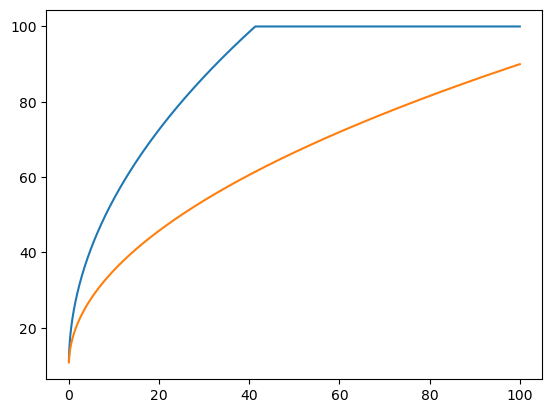

In [46]:
x = np.linspace(0.01, 100, 1000)
plt.plot(x, np.clip(14. * np.sqrt(x) + 10, None, 100));
plt.plot(x, np.clip(8. * np.sqrt(x) + 10, None, 100));

In [48]:
rgi_reg_df.loc[rgi_reg_df.o1region == '11'].area_km2.max()

81.78146453981194

In [49]:
y = d1 * sqrt(a) + d2

NameError: name 'd1' is not defined

In [50]:
d1 = 14
d2 = 10
y = 50
((y - d2)/d1)**2

8.16326530612245

In [51]:
y = 100
((y - d2)/d1)**2

41.3265306122449

In [52]:
import pandas as pd

In [73]:
x = [0.01, 1, 2, 3, 4, 5, 10, 20, 30, 40] + list(range(41, 200))

In [74]:
tdf = pd.DataFrame(index=x)

In [78]:
tdf['dx'] = np.clip(d1 * np.sqrt(x) + d2, None, 100)

In [79]:
tdf['npix'] = tdf.index * 1e6 / tdf['dx']**2

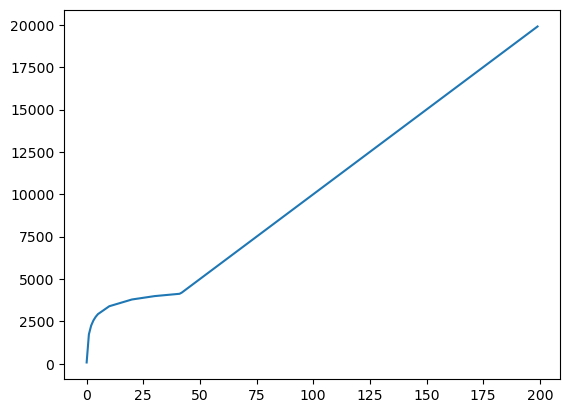

In [80]:
tdf['npix'].plot();

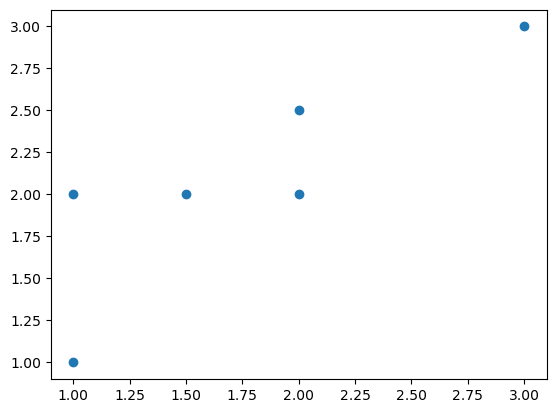

In [43]:
import numpy as np
from shapely.geometry import Point, LineString, LinearRing
from shapely.geometry.polygon import Polygon
from geopandas import GeoSeries
import matplotlib.pyplot as plt

x_data = np.array([1, 1, 1.5, 2, 2, 3]) 
y_data = np.array([1, 2, 2, 2, 2.5, 3])
p = [2, 1, 0, 3, 4, 5]

plt.plot(x_data, y_data, 'o');

In [44]:
LineString(coordinates=np.asarray((x_data, y_data)).T).length

3.618033988749895

In [45]:
LineString(coordinates=np.asarray((x_data[p], y_data[p])).T).length

4.53224755112299

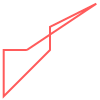

In [48]:
LinearRing(coordinates=np.asarray((x_data[p], y_data[p])).T)

In [51]:
np.argmin([1, 1, 2, 3])

0